In [75]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

In [76]:
df = pd.read_excel('Resumes (For Applicants).xlsx')

Some rows have these two columns swapped.
Looking at the Excel file, rows that have been swapped are those where **Reason_for_decision** starts with "expected_experience".
As such, we check for rows that start like that, and swap them with the **Job_Description** column.

In [77]:
swapped_indices = []

for idx, row in df.iterrows():
    reason_col = str(row['Reason_for_decision']).strip().lower()
    if reason_col.startswith('expected_experience'):
        swapped_indices.append(idx)

if len(swapped_indices) > 0:
    for idx in swapped_indices:
        df.loc[idx, 'Reason_for_decision'], df.loc[idx, 'Job_Description'] = df.loc[idx, 'Job_Description'], df.loc[idx, 'Reason_for_decision']

Convert all data to lowercase as part of preprocessing of data.

In [78]:
text_columns = df.select_dtypes(include=['object', 'string']).columns

for col in text_columns:
    df[col] = df[col].str.lower()

In [79]:
def get_email(text):
    """Gets email in Resume column using regex."""
    email = re.findall(r'\S+@\S+', str(text))
    return email[0] if email else "Not Found"

def get_phone(text):
    """Gets phone number following American format: 123-456-7890 or (123) 456-7890"""
    phone = re.findall(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4})', str(text))
    return phone[0] if phone else "Not Found"

def get_name(text):
    """Gets name from resume column.

    Names appear in specific patterns at the start of resumes:
        1. **candidate profile: Name** or **data scientist candidate profile: Name**
        2. Here's a sample/professional resume for Name
        3. **Name** (just name in bold)
        4. Plain name on first line
    """
    
    lines = str(text).split('\n')
    
    for line in lines:
        line_stripped = line.strip()
        if not line_stripped:
            continue
            
        # Pattern 1: **candidate profile: Name** or **data scientist candidate profile: Name**
        match = re.search(r'\*\*.*?candidate profile:\s*(.+?)\*\*', line_stripped, re.IGNORECASE)
        if match:
            return match.group(1).strip()
        
        # Pattern 2: Here's a sample/professional resume for Name
        match = re.search(r"here'?s?\s+a\s+(sample|professional)\s+resume\s+for\s+(.+)", line_stripped, re.IGNORECASE)
        if match:
            return match.group(2).strip()
        
        # Pattern 3: **Name** (just name in bold, no other text)
        match = re.search(r'^\*\*(.+?)\*\*$', line_stripped)
        if match:
            name = match.group(1).strip()
            # Make sure it's not a profile pattern
            if 'candidate profile' not in name.lower():
                return name
        
        # Pattern 4: Plain name (first non-empty line that doesn't match above)
        # Limit line to less than 50 characters because names are not long.
        if len(line_stripped) < 50 and not line_stripped.endswith('.'):
            return line_stripped
    
    # If no text found, return "Not Found"
    return "Not Found"

def get_education(text):
    """
    Extract education information based on the structured format:
    - Looks for "education:" or "**education:**" line (lowercase since preprocessing lowercases all text)
    - Gets the next non-empty line which contains the degree
    - Format: * bachelor of science in computer science, xyz university (2010-2014)
    - Returns only the degree part (before the comma), without university name
    Note: All text is already lowercased during preprocessing
    """
    lines = str(text).split('\n')
    found_education_header = False
    
    for i, line in enumerate(lines):
        line_stripped = line.strip()
        
        # Look for Education header (education: or **education:**) - all lowercase since preprocessing
        if not found_education_header:
            # Check if this line is the Education header (case-insensitive for safety)
            if re.match(r'^\*{0,2}education:\*{0,2}$', line_stripped, re.IGNORECASE):
                found_education_header = True
                continue
        else:
            # We found the Education header, now look for the next non-empty line
            if line_stripped:
                # Clean the line: remove leading asterisks and bold markers
                cleaned = re.sub(r'^\*+\s*', '', line_stripped)  # Remove leading asterisks
                cleaned = re.sub(r'^\*\*(.+?)\*\*', r'\1', cleaned)  # Remove bold markers
                
                # Extract degree (everything before the comma, which separates from university)
                # Format: bachelor of science in computer science, xyz university (2010-2014)
                # We want: bachelor of science in computer science
                if ',' in cleaned:
                    degree = cleaned.split(',')[0].strip()
                    return degree
                else:
                    # If no comma, return the whole line (some might not have university)
                    return cleaned
    
    # If no education found, return "Not Found"
    return "Not Found"

# This function extracts work experience (in years if mentioned)
def get_experience(text):
    # Pattern to find "X years" or "X+ years" or "X-Y years"
    # Example: "5 years of experience" or "3+ years in Python"
    exp = re.findall(r'(\d+)\+?\s*(?:-\s*\d+)?\s*years?', str(text).lower())
    if exp:
        # Convert the found number to integer and return it
        # If multiple years mentioned, take the first one
        return int(exp[0])
    else:
        # If no years mentioned, return 0
        return 0

# This function finds skills mentioned in the resume
def get_skills(text):
    # Define a comprehensive list of technical skills to look for
    # These are common skills in tech jobs
    keywords = [
        'python', 'java', 'javascript', 'sql', 'r', 'c++', 'c#',
        'machine learning', 'deep learning', 'data analysis', 'statistics',
        'tableau', 'power bi', 'excel', 'aws', 'azure', 'cloud',
        'git', 'docker', 'kubernetes', 'tensorflow', 'pytorch',
        'html', 'css', 'react', 'angular', 'node.js', 'flask', 'django'
    ]
    # Convert resume text to lowercase for easier matching
    text_lower = str(text).lower()
    # Check each skill keyword and keep the ones found in the resume
    # Use regex word boundaries (\b) to match whole words only, preventing 'r' from matching 'ready'
    found = [word for word in keywords if re.search(r'\b' + re.escape(word) + r'\b', text_lower)]
    # Join all found skills with commas, or return "None" if no skills found
    return ", ".join(found) if found else "None"

# %% [4] Apply Extraction to All Resumes
# Now we apply each extraction function to every resume in our dataset
# This creates new columns in our table (dataframe) with the extracted info

# Extract email from each resume and create a new 'Email' column
df['Email'] = df['Resume'].apply(get_email)

# Extract phone number from each resume and create a new 'Phone' column
df['Phone'] = df['Resume'].apply(get_phone)

# Extract name from each resume and create a new 'Name' column
df['Name'] = df['Resume'].apply(get_name)

# Extract education from each resume and create a new 'Education' column
df['Education'] = df['Resume'].apply(get_education)

# Extract years of experience from each resume
df['Experience_Years'] = df['Resume'].apply(get_experience)

# Extract skills from each resume and create a new 'Skills' column
df['Skills'] = df['Resume'].apply(get_skills)

## TASK 2

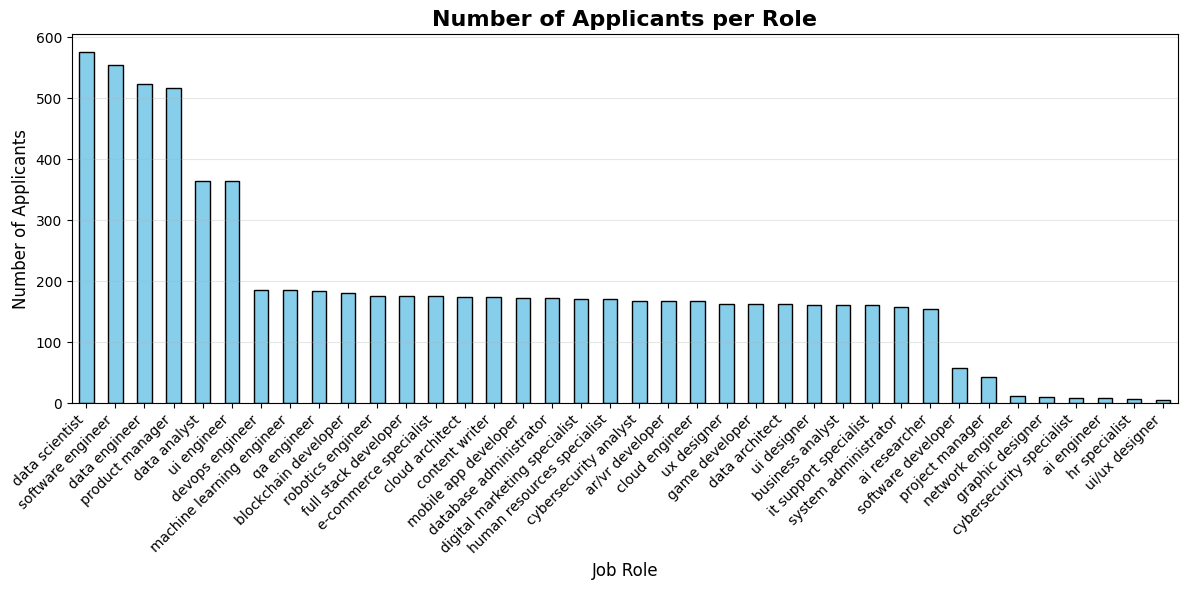

In [80]:
# Which jobs are most frequently applied for?
plt.figure(figsize=(12,6))

# Count how many applicants applied for each role and create a bar chart
# value_counts() counts occurrences of each unique role
# plot(kind='bar') makes a bar chart
df['Role'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# Add a title to explain what this chart shows
plt.title("Number of Applicants per Role", fontsize=16, fontweight='bold')

# Label the x-axis (horizontal) and y-axis (vertical)
plt.xlabel("Job Role", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)

# Rotate the x-axis labels by 45 degrees so they don't overlap
plt.xticks(rotation=45, ha='right')

# Add a grid in the background to make values easier to read
plt.grid(axis='y', alpha=0.3)

# tight_layout() ensures nothing gets cut off
plt.tight_layout()

# Display the chart
plt.show()

In [81]:
def clean_education(text):
    """
    Cleans raw education text and extracts the main field of study.
    Returns standardized category names for easier analysis.
    """
    if pd.isna(text) or text == "Not Found" or not text:
        return "Not Found"
    
    # Convert to lowercase for easier pattern matching
    text_lower = str(text).lower()
    
    # Define patterns for common fields of study
    # Check in order of specificity (most specific first)
    
    if any(word in text_lower for word in ['computer science', 'cs', 'computer engineering', 'computing']):
        return "Computer Science"
    elif any(word in text_lower for word in ['data science', 'data analytics', 'data engineering']):
        return "Data Science"
    elif any(word in text_lower for word in ['information technology', 'it', 'information systems']):
        return "Information Technology"
    elif any(word in text_lower for word in ['software engineering', 'software development']):
        return "Software Engineering"
    elif any(word in text_lower for word in ['electrical engineering', 'electronics', 'ece']):
        return "Electrical Engineering"
    elif any(word in text_lower for word in ['mechanical engineering', 'manufacturing']):
        return "Mechanical Engineering"
    elif any(word in text_lower for word in ['civil engineering']):
        return "Civil Engineering"
    elif 'engineering' in text_lower:
        return "Engineering (Other)"
    elif any(word in text_lower for word in ['business administration', 'mba', 'business management']):
        return "Business Administration"
    elif any(word in text_lower for word in ['finance', 'accounting', 'economics']):
        return "Finance/Economics"
    elif any(word in text_lower for word in ['marketing', 'sales']):
        return "Marketing"
    elif any(word in text_lower for word in ['mathematics', 'statistics', 'math']):
        return "Mathematics/Statistics"
    elif any(word in text_lower for word in ['physics', 'chemistry', 'biology']):
        return "Natural Sciences"
    elif any(word in text_lower for word in ['arts', 'humanities', 'literature', 'history']):
        return "Arts/Humanities"
    elif any(word in text_lower for word in ['bachelor', 'master', 'phd', 'degree', 'diploma']):
        return "Other Degree"
    else:
        return "Other"

print("✓ Education cleaning function defined")
print("This function will categorize education backgrounds into standard fields")

df['Education_Clean'] = df['Education'].apply(clean_education)

✓ Education cleaning function defined
This function will categorize education backgrounds into standard fields


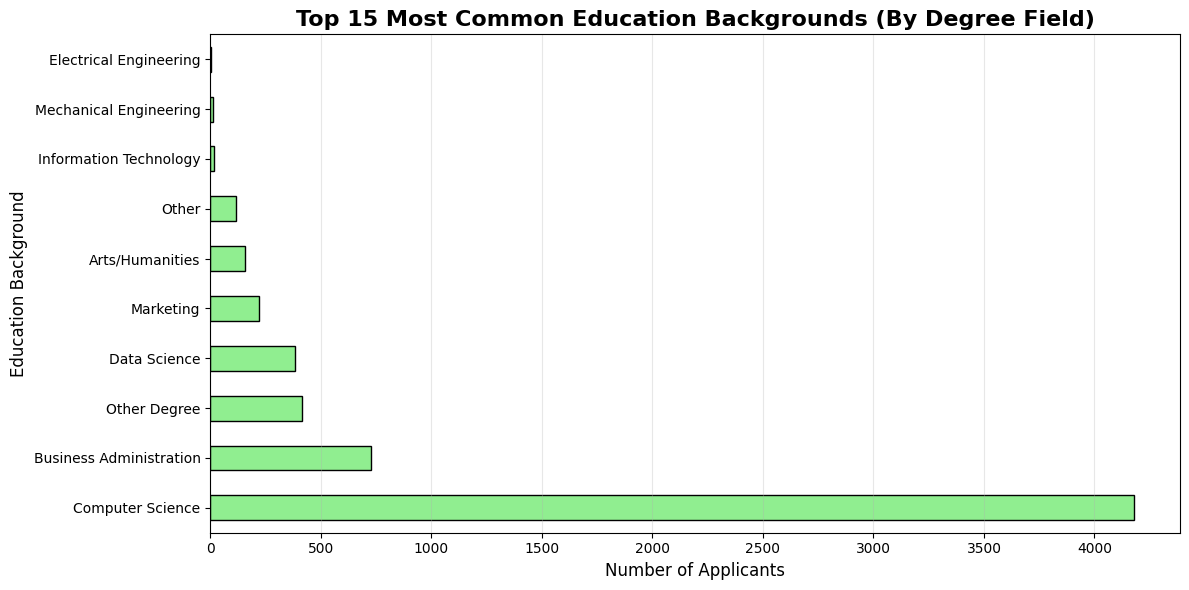

In [82]:
plt.figure(figsize=(12,6))

# Count the top 15 most common education entries (using cleaned data)
# We use .head(15) to get only the top 15 to avoid cluttering
# Filter out "Not Found" entries for cleaner visualization
education_counts = df[df['Education_Clean'] != 'Not Found']['Education_Clean'].value_counts().head(15)

# Create a horizontal bar chart (barh means horizontal bars)
# Horizontal is better when we have long text labels
education_counts.plot(kind='barh', color='lightgreen', edgecolor='black')

# Add title and labels
plt.title("Top 15 Most Common Education Backgrounds (By Degree Field)", fontsize=16, fontweight='bold')
plt.xlabel("Number of Applicants", fontsize=12)
plt.ylabel("Education Background", fontsize=12)

# Add grid for easier reading
plt.grid(axis='x', alpha=0.3)

# Adjust layout and show
plt.tight_layout()
plt.show()

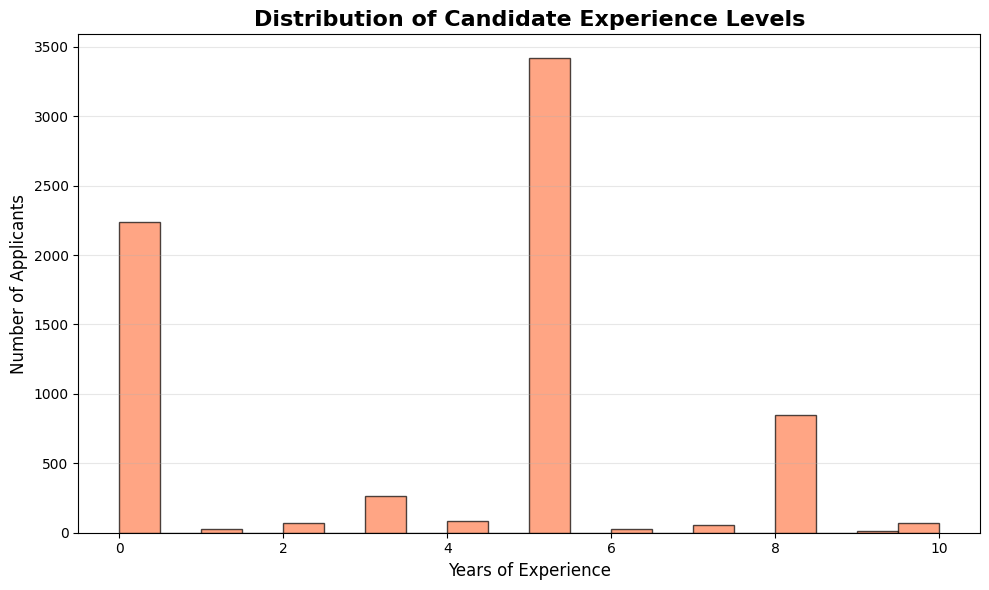

In [83]:
# Distribution of Experience Levels
# This shows the typical profile of candidates based on their experience

# Create a figure with better size
plt.figure(figsize=(10,6))

# Create a histogram showing distribution of experience years
# bins=20 means we divide the data into 20 groups
# A histogram shows how many people fall into each experience range
plt.hist(df['Experience_Years'], bins=20, color='coral', edgecolor='black', alpha=0.7)

# Add title and labels
plt.title("Distribution of Candidate Experience Levels", fontsize=16, fontweight='bold')
plt.xlabel("Years of Experience", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)

# Add a grid for easier reading
plt.grid(axis='y', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

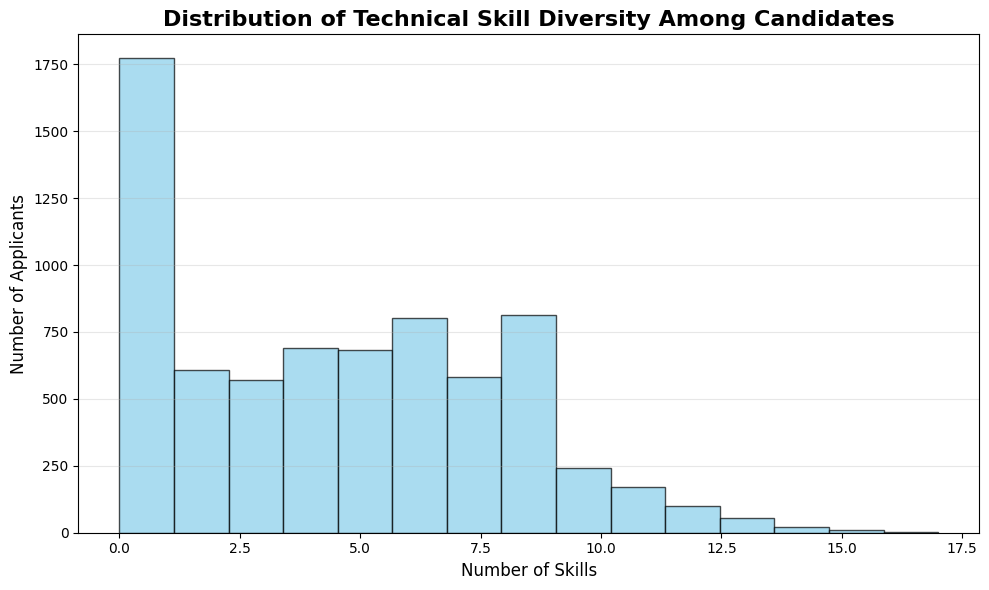

In [84]:
# Skills Distribution Analysis
# Count how many skills each person has (we'll use this throughout the analysis)
df['Skill_Count'] = df['Skills'].apply(lambda x: len(str(x).split(',')) if x != 'None' else 0)

# Create a histogram showing distribution of skill counts
plt.figure(figsize=(10,6))
plt.hist(df['Skill_Count'], bins=15, color='skyblue', edgecolor='black', alpha=0.7)

# Add title and labels
plt.title("Distribution of Technical Skill Diversity Among Candidates", fontsize=16, fontweight='bold')
plt.xlabel("Number of Skills", fontsize=12)
plt.ylabel("Number of Applicants", fontsize=12)

# Add a grid for easier reading
plt.grid(axis='y', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

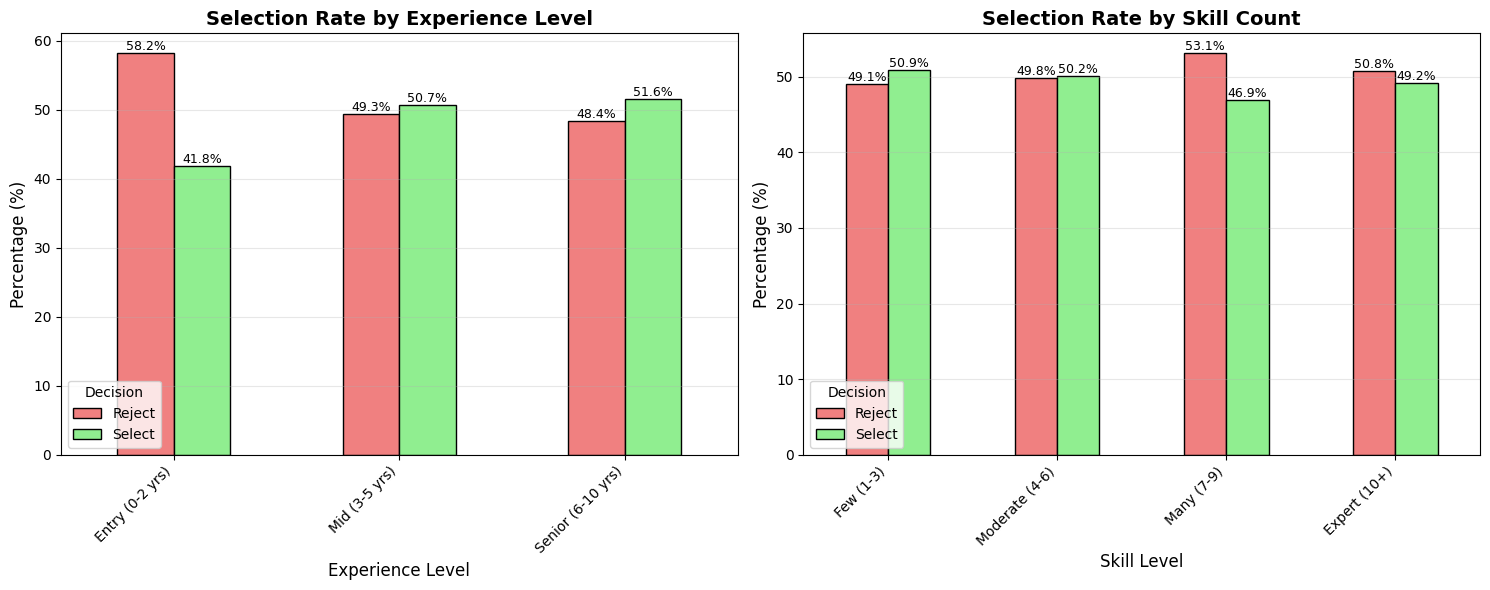

In [85]:
# Decision Patterns by Experience Level
# Create experience level categories for better analysis
df['Experience_Level'] = pd.cut(df['Experience_Years'], 
                                bins=[0, 2, 5, 10, 50],
                                labels=['Entry (0-2 yrs)', 'Mid (3-5 yrs)', 
                                       'Senior (6-10 yrs)', 'Expert (10+ yrs)'])

# Create a grouped analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: Decision by Experience Level
exp_decision = pd.crosstab(df['Experience_Level'], df['Decision'], normalize='index') * 100
exp_decision.plot(kind='bar', ax=axes[0], color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[0].set_title("Selection Rate by Experience Level", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Experience Level", fontsize=12)
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(title="Decision", labels=['Reject', 'Select'])
axes[0].grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', fontsize=9)

# Right: Decision by Skill Count bins
df['Skill_Level'] = pd.cut(df['Skill_Count'],
                           bins=[0, 3, 6, 9, 30],
                           labels=['Few (1-3)', 'Moderate (4-6)', 'Many (7-9)', 'Expert (10+)'])

skill_decision = pd.crosstab(df['Skill_Level'], df['Decision'], normalize='index') * 100
skill_decision.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'], edgecolor='black')
axes[1].set_title("Selection Rate by Skill Count", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Skill Level", fontsize=12)
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Decision", labels=['Reject', 'Select'])
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', fontsize=9)

plt.tight_layout()
plt.show()

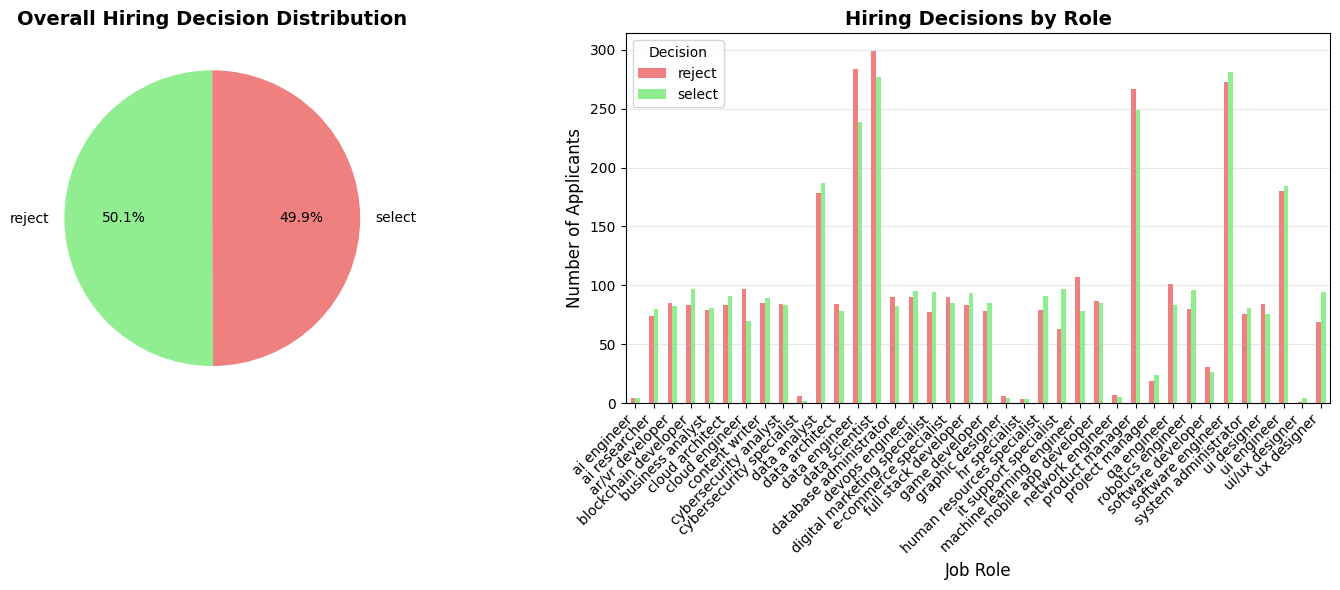

In [86]:
# Patterns in Hired vs Rejected Candidates

# Create a figure with two subplots side by side
# subplot(1, 2, 1) means: 1 row, 2 columns, this is position 1
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left chart: Decision distribution (how many selected vs rejected)
# value_counts() counts how many "Select" and how many "Reject"
df['Decision'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', 
                                    colors=['lightgreen', 'lightcoral'],
                                    startangle=90)
# autopct='%1.1f%%' means show percentages with 1 decimal place
# startangle=90 means start the pie from the top

# Add title to the left chart
axes[0].set_title("Overall Hiring Decision Distribution", fontsize=14, fontweight='bold')
# Remove the y-label (pie charts don't need them)
axes[0].set_ylabel('')

# Right chart: Decision by Role
# crosstab creates a table showing how many selected/rejected for each role
decision_by_role = pd.crosstab(df['Role'], df['Decision'])
# Plot as a stacked bar chart
decision_by_role.plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'])

# Add title and labels to the right chart
axes[1].set_title("Hiring Decisions by Role", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Job Role", fontsize=12)
axes[1].set_ylabel("Number of Applicants", fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].legend(title="Decision")
axes[1].grid(axis='y', alpha=0.3)

# Adjust layout so nothing overlaps
plt.tight_layout()
plt.show()

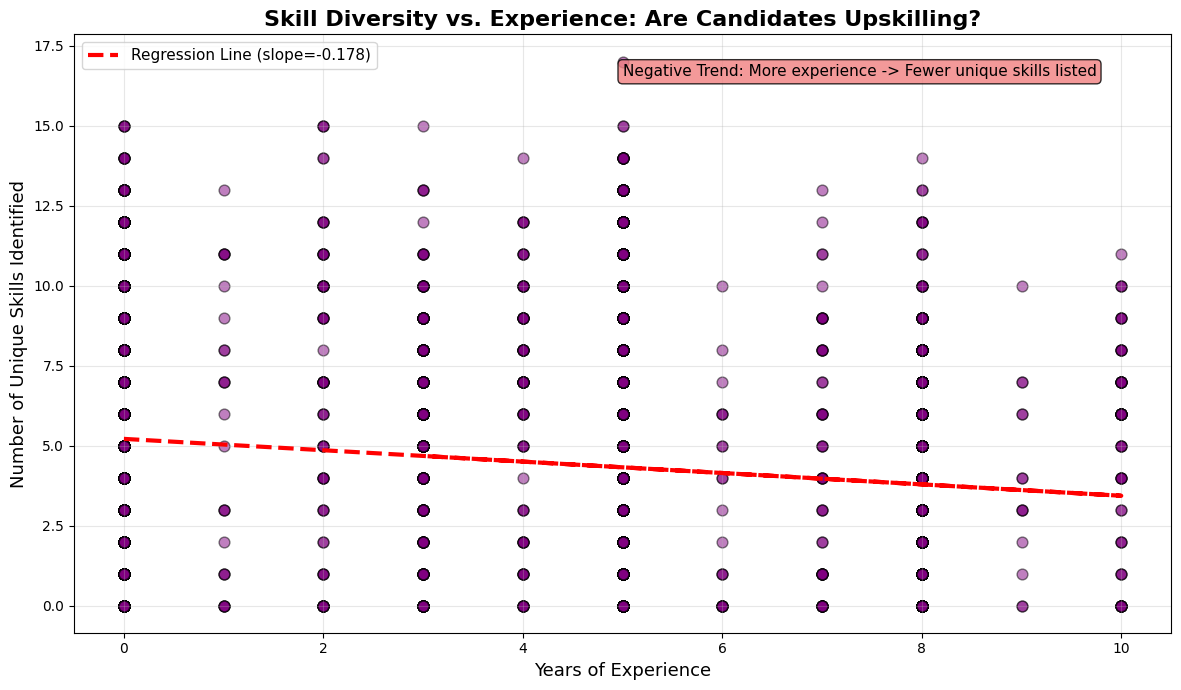

In [87]:
# Skill Diversity vs. Experience (Scatter Plot with Regression Line)
# Do people with more experience have more diverse skills?
# If the line slopes upward, more experienced candidates are "upskilling"
# If it's flat, skillsets might plateau after a certain career stage

# Note: Skill_Count was already calculated in Cell 7b, so we can use it directly

# Create a scatter plot (dots) showing experience vs number of skills
plt.figure(figsize=(12, 7))

# Each dot represents one candidate
# x-axis is their experience, y-axis is their number of skills
# alpha=0.5 makes dots semi-transparent so we can see overlapping points
plt.scatter(df['Experience_Years'], df['Skill_Count'], alpha=0.5, 
            color='purple', edgecolors='black', s=60)

# Add a regression line to see if there's a relationship
# polyfit finds the best line through the data (degree 1 = straight line)
z = np.polyfit(df['Experience_Years'], df['Skill_Count'], 1)
p = np.poly1d(z)
slope = z[0]  # Extract the slope of the line

# Plot the regression line in red with dashes
plt.plot(df['Experience_Years'], p(df['Experience_Years']), 
         "r--", linewidth=3, label=f'Regression Line (slope={slope:.3f})')

# Add title and labels
plt.title("Skill Diversity vs. Experience: Are Candidates Upskilling?", 
          fontsize=16, fontweight='bold')
plt.xlabel("Years of Experience", fontsize=13)
plt.ylabel("Number of Unique Skills Identified", fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)

# Add annotations
if slope > 0.1:
    plt.text(0.5, 0.95, 'Positive Trend: More experience -> More skills', 
             transform=plt.gca().transAxes, fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
             verticalalignment='top')
elif slope < -0.1:
    plt.text(0.5, 0.95, 'Negative Trend: More experience -> Fewer unique skills listed', 
             transform=plt.gca().transAxes, fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
             verticalalignment='top')
else:
    plt.text(0.5, 0.95, 'Flat Trend: Experience and skills not strongly correlated', 
             transform=plt.gca().transAxes, fontsize=11, 
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
             verticalalignment='top')

plt.tight_layout()
plt.show()

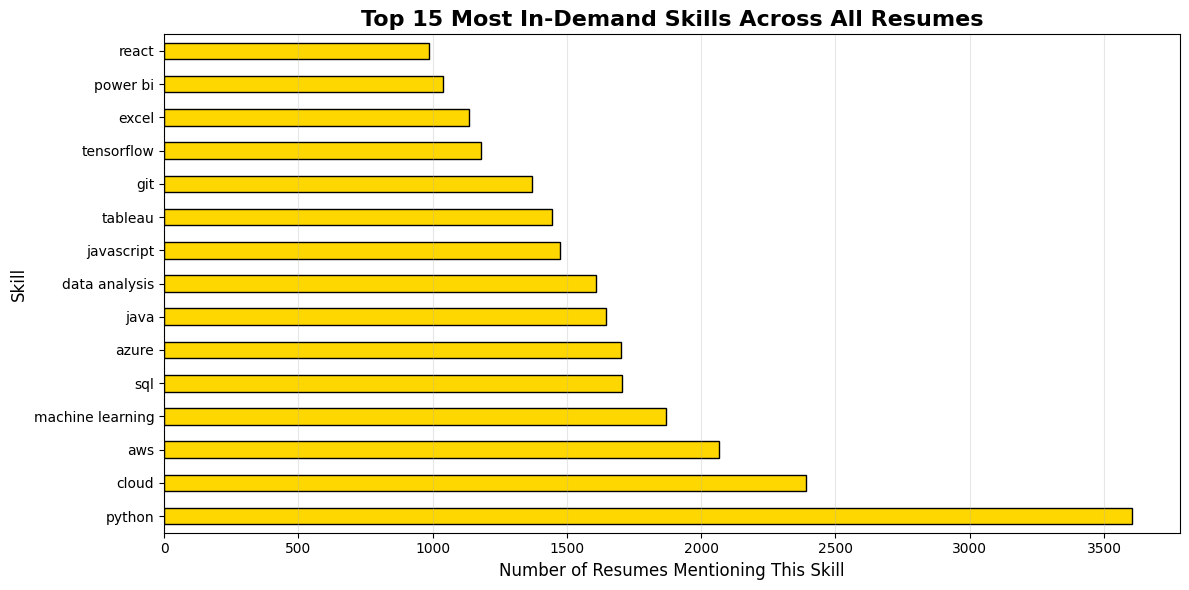

In [ ]:
# Top Skills in Demand
# What are the most commonly mentioned skills across all resumes?

# Create an empty list to collect all skills
all_skills = []

# Go through each resume's skills
for skills in df['Skills']:
    # If skills exist (not "None")
    if skills != 'None':
        # Split by comma to get individual skills
        # strip() removes extra spaces
        skill_list = [s.strip() for s in str(skills).split(',')]
        # Add these skills to our master list
        all_skills.extend(skill_list)

# Count how often each skill appears
# pd.Series converts our list to a pandas object so we can use value_counts()
skill_counts = pd.Series(all_skills).value_counts().head(15)

# Create a bar chart of top skills
plt.figure(figsize=(12, 6))
skill_counts.plot(kind='barh', color='gold', edgecolor='black')

# Add title and labels
plt.title("Top 15 Most In-Demand Technical Skills Across All Resumes", fontsize=16, fontweight='bold')
plt.xlabel("Number of Resumes Mentioning This Skill", fontsize=12)
plt.ylabel("Skill", fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Adjust and display
plt.tight_layout()
plt.show()